In [2]:
# init dummy calcs

from pymatgen.core import Structure
from copy import deepcopy

host = Structure.from_file('LiF_mp-1138_conventional_standard.cif')
host.make_supercell(2)

Li_vacancy = deepcopy(host)
Li_vacancy.remove_sites([0])
F_vacancy = deepcopy(host)
F_vacancy.remove_sites([32])

from pymatgen.io.vasp.sets import MPRelaxSet

host_calc = MPRelaxSet(host, user_incar_settings={'ISIF':2, 'EDIFFG':-0.05})
Li_vacancy_calc = MPRelaxSet(Li_vacancy, user_incar_settings={'ISIF':2, 'EDIFFG':-0.05, 'NELECT':host_calc.nelect+1})
F_vacancy_calc = MPRelaxSet(F_vacancy, user_incar_settings={'ISIF':2, 'EDIFFG':-0.05, 'NELECT':host_calc.nelect-1})

Li_vacancy_calc.write_input('v_Li')
F_vacancy_calc.write_input('v_F')
host_calc.write_input('host')

/home/alex/.pyenv/versions/3.8.2/lib/python3.8/site-packages/pymatgen/io/vasp/sets.py:129: BadInputSetWarning: POTCAR data with symbol Li_sv is not known by pymatgen to                    correspond with the selected potcar_functional PBE. This POTCAR                    is known to correspond with functionals ['unvie_PBE_52', 'PBE_52', 'PBE_54']. Please verify that                    you are using the right POTCARs!
  warnings.warn(
/home/alex/.pyenv/versions/3.8.2/lib/python3.8/site-packages/pymatgen/io/vasp/sets.py:129: BadInputSetWarning: POTCAR data with symbol F is not known by pymatgen to                    correspond with the selected potcar_functional PBE. This POTCAR                    is known to correspond with functionals ['unvie_PBE_52', 'PBE_52', 'PBE_54']. Please verify that                    you are using the right POTCARs!
  warnings.warn(


/home/alex/.pyenv/versions/3.8.2/lib/python3.8/site-packages/pymatgen/io/vasp/sets.py:129: BadInputSetWarning: POTCAR data with symbol Li_sv is not known by pymatgen to                    correspond with the selected potcar_functional PBE. This POTCAR                    is known to correspond with functionals ['unvie_PBE_52', 'PBE_52', 'PBE_54']. Please verify that                    you are using the right POTCARs!
  warnings.warn(
/home/alex/.pyenv/versions/3.8.2/lib/python3.8/site-packages/pymatgen/io/vasp/sets.py:129: BadInputSetWarning: POTCAR data with symbol F is not known by pymatgen to                    correspond with the selected potcar_functional PBE. This POTCAR                    is known to correspond with functionals ['unvie_PBE_52', 'PBE_52', 'PBE_54']. Please verify that                    you are using the right POTCARs!
  warnings.warn(


(0.0, 400.0)

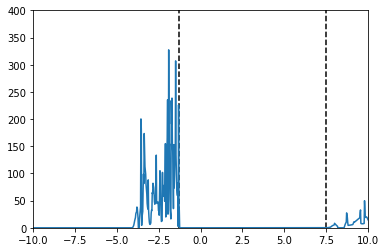

In [3]:
# manual DOS object generation

from vasppy.doscar import Doscar
from py_sc_fermi.dos import DOS
import numpy as np
import matplotlib.pyplot as plt

host_doscar = Doscar('DOSCAR_SP.txt')
vbm = host_doscar.efermi
edos = host_doscar.tdos
unoccupied_states = edos[edos['energy'] > vbm]
cbm = unoccupied_states[unoccupied_states['up'] + unoccupied_states['down'] > 0.00001].iloc[0]['energy']
bandgap = cbm - vbm

dos = DOS(np.array(edos['up']) + np.array(edos['down']), np.array(edos['energy']), bandgap, nelect=host_calc.nelect)

plt.plot(dos.edos,dos.dos)
plt.vlines(vbm, 0, 1000, color = 'black', ls='--')
plt.vlines(cbm, 0, 1000, color = 'black', ls='--')
plt.xlim(-10,10)
plt.ylim(0,400)

/home/alex/.pyenv/versions/3.8.2/lib/python3.8/site-packages/pymatgen/io/vasp/sets.py:129: BadInputSetWarning: POTCAR data with symbol Li_sv is not known by pymatgen to                    correspond with the selected potcar_functional PBE. This POTCAR                    is known to correspond with functionals ['unvie_PBE_52', 'PBE_52', 'PBE_54']. Please verify that                    you are using the right POTCARs!
  warnings.warn(
/home/alex/.pyenv/versions/3.8.2/lib/python3.8/site-packages/pymatgen/io/vasp/sets.py:129: BadInputSetWarning: POTCAR data with symbol F is not known by pymatgen to                    correspond with the selected potcar_functional PBE. This POTCAR                    is known to correspond with functionals ['unvie_PBE_52', 'PBE_52', 'PBE_54']. Please verify that                    you are using the right POTCARs!
  warnings.warn(
/home/alex/.pyenv/versions/3.8.2/lib/python3.8/site-packages/pymatgen/io/vasp/outputs.py:1014: UserWarning: No POTCAR file with ma

(0.0, 400.0)

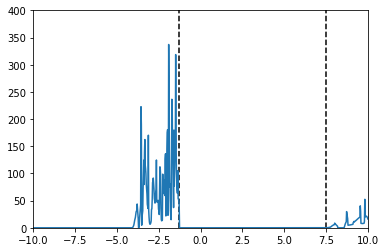

In [25]:
from pymatgen.io.vasp import Vasprun

def DOS_from_vasprun(doscar, nelect):
    """
    generate DOS object (py_sc_fermi.dos) from a vasp 
    doscar given number of electrons in calculation
    
    Args:
        doscar (string): path to DOSCAR to parse
        nelect (float): number of electrons in vasp calculation
    
    Returns:
        dos (DOS): DOS object 
    """
    vr = Vasprun('vasprun_nsp.xml')
    cbm, vbm = vr.tdos.get_cbm_vbm()
    edos = sum(vr.tdos.densities.values())
    energies = vr.tdos.energies
    bandgap = vr.tdos.get_gap()
    dos = DOS(edos, energies, bandgap, nelect=host_calc.nelect)
    return dos
    
dos = DOS_from_vasprun('vasprun_nsp.xml',host_calc.nelect)

plt.plot(dos.edos,dos.dos)
plt.vlines(vbm, 0, 1000, color = 'black', ls='--')
plt.vlines(cbm, 0, 1000, color = 'black', ls='--')
plt.xlim(-10,10)
plt.ylim(0,400)

In [26]:
from pymatgen.core import Structure

def volume_from_structure(structure_file):
    """
    return volume in A^3 for a given structure file. Relies on pymatgen structure parser
    so accepts a wide range of formats inc. POSCAR, .cif, vasp output files (OUTCAR, vasprun.xml) etc.
    
    Args:
        structure_file (str): path to structure file to parse
    
    Returns:
        volume (float): volume of structure in A^3
    """
    structure = Structure.from_file(structure_file)
    volume = structure.volume
    return volume

volume = volume_from_structure('vasprun.xml')

host_DFT_energy = -308.50975379
v_F_DFT_energy = -304.63905419
v_Li_DFT_energy = -301.33048584

raw_v_F_energy = v_F_DFT_energy - -308.50975379
raw_v_Li_energy = v_Li_DFT_energy - -308.50975379

/home/alex/.pyenv/versions/3.8.2/lib/python3.8/site-packages/pymatgen/io/vasp/outputs.py:1014: UserWarning: No POTCAR file with matching TITEL fields was found in /mnt/a/materials_2/LiF
  warnings.warn("No POTCAR file with matching TITEL fields" " was found in {}".format(os.path.abspath(p)))


In [27]:
from pymatgen.ext.matproj import MPRester
from pymatgen.analysis.phase_diagram import PhaseDiagram
from pymatgen.core import Element, Composition

#This initializes the REST adaptor. Put your own API key in if necessary.
mp_rest = MPRester()

#This gets all entries belonging to the Ca-C-O system.
all_entries = mp_rest.get_entries_in_chemsys(['Li','F'])
phase_diagram = PhaseDiagram(all_entries)
chemical_potentials = phase_diagram.get_chempot_range_stability_phase(Composition({'Li':1,'F':1}),Element['F'])

defect_formation_energy_v_F = raw_v_F_energy + 1 * chemical_potentials[Element['F']][0] + 1 * vbm
defect_formation_energy_v_Li = raw_v_Li_energy - 1 * chemical_potentials[Element['Li']][0] + -1 * vbm

/home/alex/.pyenv/versions/3.8.2/lib/python3.8/site-packages/pymatgen/ext/matproj.py:567: FutureWarning: __init__ is deprecated
MaterialsProjectCompatibility will be updated with new correction classes as well as new values of corrections and uncertainties in 2020
  entries = MaterialsProjectCompatibility().process_entries(entries)


Text(0, 0.5, 'E_formation / eV')

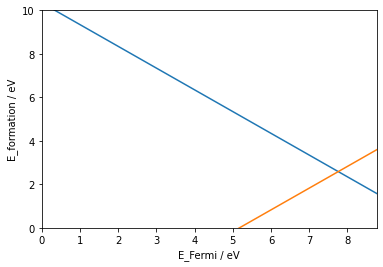

In [28]:
from py_sc_fermi.defect_system import DefectSystem
from py_sc_fermi.defect_species import DefectSpecies
from py_sc_fermi.defect_charge_state import DefectChargeState

v_Li = DefectSpecies('v_Li', 32, [DefectChargeState(-1, defect_formation_energy_v_Li, 1)])
v_F = DefectSpecies('v_F', 32, [DefectChargeState(1, defect_formation_energy_v_F, 1)])
defect_system = DefectSystem([v_Li, v_F], dos, volume, temperature=1000, spin_pol=1)

plt.plot(defect_system.get_transition_levels()['v_Li'][0], defect_system.get_transition_levels()['v_Li'][1])
plt.plot(defect_system.get_transition_levels()['v_F'][0], defect_system.get_transition_levels()['v_F'][1])
plt.xlim(0, cbm-vbm)
plt.ylim(0,10)

plt.xlabel('E_Fermi / eV')
plt.ylabel('E_formation / eV')

/mnt/a/materials_2/py-sc-fermi/py_sc_fermi/dos.py:94: RuntimeWarning: overflow encountered in exp
  return dos / (1.0 + np.exp((e_fermi - edos)/kT))


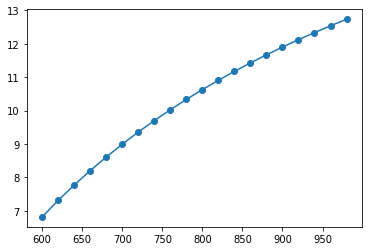

In [29]:
from py_sc_fermi.defect_system import DefectSystem
from py_sc_fermi.defect_species import DefectSpecies
from py_sc_fermi.defect_charge_state import DefectChargeState

v_Li = DefectSpecies('v_Li', 32, [DefectChargeState(-1, defect_formation_energy_v_Li, 1)])
v_F = DefectSpecies('v_F', 32, [DefectChargeState(1, defect_formation_energy_v_F, 1)])


v_li_concentrations = []
v_f_concentrations = []
for temperature in np.arange(600,1000,20):
    defect_system = DefectSystem([v_Li, v_F], dos, volume, temperature=temperature, spin_pol=1)
    defect_system_data = defect_system.to_dict()
    v_li_concentrations.append(defect_system_data['v_Li'])
    v_f_concentrations.append(defect_system_data['v_F'])


plt.plot(np.arange(600,1000,20),np.log10(v_f_concentrations), '-o')

###



/mnt/a/materials_2/py-sc-fermi/py_sc_fermi/dos.py:94: RuntimeWarning: overflow encountered in exp
  return dos / (1.0 + np.exp((e_fermi - edos)/kT))


Text(0, 0.5, 'defect concentration / cm^3')

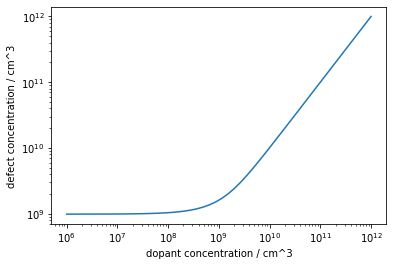

In [23]:
from py_sc_fermi.defect_charge_state import FrozenDefectChargeState

dopants = np.logspace(6,12)

v_li_concentrations = []
v_f_concentrations = []
for dopant_concentration in dopants:
    dopant_charge_state = FrozenDefectChargeState(1,dopant_concentration/1e24 * defect_system.volume)
    defect_system = DefectSystem([v_Li, v_F, DefectSpecies('dopant',-1,[dopant_charge_state])], dos, volume, temperature=700, spin_pol=1)
    defect_system_data = defect_system.to_dict()
    v_li_concentrations.append(defect_system_data['v_Li'])
    v_f_concentrations.append(defect_system_data['v_F'])

plt.yscale('log')
plt.xscale('log')
plt.plot(dopants,v_f_concentrations)

plt.xlabel('dopant concentration / cm^3')
plt.ylabel('defect concentration / cm^3')

In [24]:
defect_system.write_inputs()